In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

<h1> Load Dataset</h1>

In [2]:
data = pd.read_csv('data/005930.KS.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4989 non-null   object 
 1   Open       4989 non-null   float64
 2   High       4989 non-null   float64
 3   Low        4989 non-null   float64
 4   Close      4989 non-null   float64
 5   Adj Close  4989 non-null   float64
 6   Volume     4989 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 273.0+ KB


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4984,2023-01-16,61300.0,61600.0,60800.0,61100.0,61100.0,10039972
4985,2023-01-17,61200.0,61500.0,60600.0,61000.0,61000.0,9831456
4986,2023-01-18,60700.0,61000.0,59900.0,60400.0,60400.0,11584041
4987,2023-01-19,60500.0,61500.0,60400.0,61500.0,61500.0,12808490
4988,2023-01-20,62100.0,62300.0,61100.0,61800.0,61800.0,9646327


# Compute Mid Price

In [5]:
high_price = data['High'].values
low_price = data['Low'].values
mid_price = (high_price + low_price)/2

# Creat windows
###### LSTM을 사용시 seq_len 만큼의 데이터를 보고 그 다음을 예측 

In [9]:
seq_len = 50
sequence_length = seq_len + 5

result = []
for index in range(len(mid_price) - sequence_length):
    result.append(mid_price[index:index + sequence_length])

# Normalize Data

In [10]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-5]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -5]

x_test = result[row:, :-5]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -5]

x_train.shape, y_train.shape, x_test.shape

((4441, 50, 1), (4441,), (493, 50, 1))

# Build a Model

In [11]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [12]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
445/445 [==============================] - 18s 30ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2/20
445/445 [==============================] - 12s 28ms/step - loss: 3.6070e-04 - val_loss: 3.3292e-04
Epoch 3/20
445/445 [==============================] - 12s 28ms/step - loss: 2.9939e-04 - val_loss: 3.1989e-04
Epoch 4/20
445/445 [==============================] - 13s 28ms/step - loss: 2.9200e-04 - val_loss: 1.6247e-04
Epoch 5/20
445/445 [==============================] - 13s 29ms/step - loss: 2.8883e-04 - val_loss: 2.3219e-04
Epoch 6/20
445/445 [==============================] - 13s 29ms/step - loss: 2.8446e-04 - val_loss: 4.3271e-04
Epoch 7/20
445/445 [==============================] - 13s 29ms/step - loss: 2.8191e-04 - val_loss: 2.2664e-04
Epoch 8/20
445/445 [==============================] - 13s 28ms/step - loss: 2.8374e-04 - val_loss: 4.0830e-04
Epoch 9/20
445/445 [==============================] - 13s 29ms/step - loss: 2.7887e-04 - val_loss: 2.4563e-04
Epoch 10/20
445/44

# Prediction

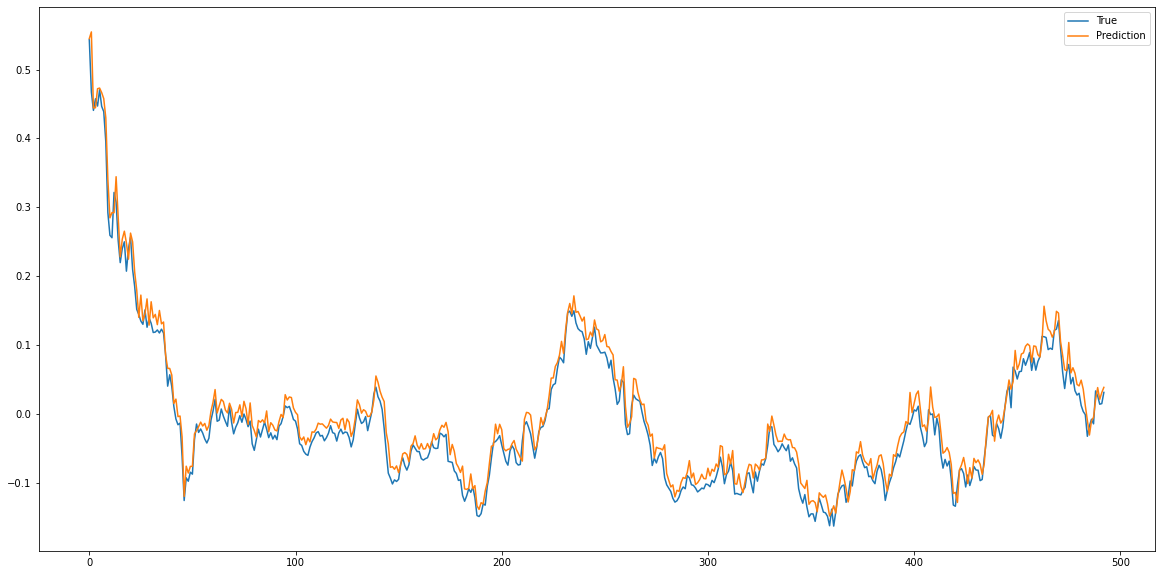

In [13]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()